### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd './drive/My Drive/NLP/day17'

/content/drive/My Drive/NLP/day17


In [ ]:
!ls

spam.csv  計數方法詞向量實作.ipynb  計數方法詞向量實作_作業.ipynb


In [4]:
# read data from spam.csv
# quoting:https://blog.csdn.net/sinat_39416814/article/details/105579201
sms_data = pd.read_csv(filepath_or_buffer = 'spam.csv'  ,header = 0 , encoding='latin' , usecols=[0,1] ,index_col=False)
sms_data.columns = ['label' , 'content']
###<your code>###
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# check how many spams and hams
###<your code>###
sms_data.groupby("label").count()

,content
label,
ham,4825
spam,747


In [6]:
# How do I filter specific rows from a DataFrame?¶
# v.s How do I select specific rows and columns from a DataFrame?¶
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
sms_data[sms_data['label'] == 'ham']
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
###<your code>###
sms_data.loc[sms_data.loc[:, "label"] == "spam", "label"] = 1
sms_data.loc[sms_data.loc[:, "label"] == "ham", "label"] = 0
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [8]:
###<your code>###
# https://blog.csdn.net/liuxiao214/article/details/79019901
sms_train , sms_test = train_test_split(sms_data , test_size = 0.2)
sms_train.reset_index(inplace=True, drop=True)
sms_test.reset_index(inplace=True, drop=True)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3858
1          599
       content
label         
0          967
1          148


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        ###<your code>###
        df.loc[i , 'content'] = df.loc[i , 'content'].lower()
        # remove all punctuations
        ###<your code>###
        df.loc[i , 'content'] = re.sub(pattern='[^a-zA-Z]+' , repl=' ' , string = df.loc[i , 'content'])
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Train:
  label                                            content
0     0   do u hav any frnd by name ashwini in ur college 
1     0  arngd marriage is while u r walkin unfortuntly...
2     0  yalru lyfu astne chikku bt innu mundhe lyf ali...
3     0  can not use foreign stamps in this country goo...
4     0  well boy am i glad g wasted all night at apple...
Test:
  label                                            content
0     0  i m used to it i just hope my agents don t dro...
1     0   oh yes i can speak txt u no hmm did u get email 
2     0                   wat s my dear doing sleeping ah 
3     0    moji i love you more than words have a rich day
4     0                                  all write or wat 


In [10]:
print(type(processed_test))

<class 'pandas.core.frame.DataFrame'>


In [11]:
# split data into x_train, y_train, x_test, y_test
# https://stackoverflow.com/questions/33802940/python-pandas-meaning-of-asterisk-sign-in-expression
# zip() in conjunction with the * operator can be used to unzip a list
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

print(type(y_train))
# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

<class 'tuple'>


7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [12]:
print(x_train)

('do u hav any frnd by name ashwini in ur college ', 'arngd marriage is while u r walkin unfortuntly a snake bites u bt love marriage is dancing in frnt of d snake amp sayin bite me bite me ', 'yalru lyfu astne chikku bt innu mundhe lyf ali halla ke bilo marriage program edhae so lyf is nt yet ovr chikku ali vargu lyfu meow meow d', 'can not use foreign stamps in this country good lecture ', 'well boy am i glad g wasted all night at applebees for nothing', 'aathi where are you dear ', 'is ur paper today in e morn or aft ', 'a xmas reward is waiting for you our computer has randomly picked you from our loyal mobile customers to receive a reward just call ', 'i am seeking a lady in the street and a freak in the sheets is that you ', 'ok i juz receive ', 'it does it on its own most of the time it fixes my spelling but sometimes it gets a completely diff word go figure', ' ok i feel like john lennon ', 'that sucks i ll go over so u can do my hair you ll do it free right ', 'want to finally

In [13]:
###<your code>###
# If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features
vectorizer = TfidfVectorizer(max_features = 2000)
vectorizer.fit(x_train)

tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)
# https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 50993 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12460 stored elements in Compressed Sparse Row format>)

In [14]:
print(tfidf_train)

  (0, 1804)	0.2457720383305736
  (0, 1119)	0.3658835273057007
  (0, 805)	0.18655748832823618
  (0, 718)	0.40132097327398153
  (0, 615)	0.43785727962857035
  (0, 444)	0.24127216977749272
  (0, 317)	0.42869344932625497
  (0, 233)	0.28798852648635337
  (0, 72)	0.3053136214851262
  (1, 1902)	0.23920437087482951
  (1, 1537)	0.6200722335008463
  (1, 1166)	0.12354208274151193
  (1, 1024)	0.23174787992868606
  (1, 1007)	0.5568020268655072
  (1, 974)	0.166285231893102
  (1, 834)	0.22258752706224866
  (1, 805)	0.10877046606649546
  (1, 220)	0.2216560988137225
  (1, 63)	0.20281776311627492
  (2, 1982)	0.30012558417696356
  (2, 1539)	0.1861195374225979
  (2, 1158)	0.3350508999593017
  (2, 1007)	0.389953200934762
  (2, 834)	0.15588793588756572
  (2, 287)	0.7001914834152895
  :	:
  (4454, 238)	0.39203846119603897
  (4455, 1678)	0.4291677905691717
  (4455, 1459)	0.9032247823980338
  (4456, 1990)	0.515278701876903
  (4456, 1894)	0.1301172299606591
  (4456, 1724)	0.14880191794929282
  (4456, 1723)	0.07

In [15]:
vectorizer.vocabulary_

{'do': 444,
 'hav': 718,
 'any': 72,
 'frnd': 615,
 'by': 233,
 'name': 1119,
 'in': 805,
 'ur': 1804,
 'college': 317,
 'marriage': 1007,
 'is': 834,
 'while': 1902,
 'snake': 1537,
 'bt': 220,
 'love': 974,
 'of': 1166,
 'amp': 63,
 'me': 1024,
 'chikku': 287,
 'so': 1539,
 'nt': 1158,
 'yet': 1982,
 'can': 247,
 'not': 1153,
 'use': 1811,
 'this': 1695,
 'country': 357,
 'good': 669,
 'lecture': 916,
 'well': 1888,
 'boy': 206,
 'am': 61,
 'glad': 657,
 'all': 52,
 'night': 1139,
 'at': 110,
 'for': 592,
 'nothing': 1155,
 'aathi': 0,
 'where': 1899,
 'are': 89,
 'you': 1990,
 'dear': 405,
 'paper': 1216,
 'today': 1724,
 'morn': 1085,
 'or': 1192,
 'aft': 30,
 'xmas': 1965,
 'reward': 1398,
 'waiting': 1846,
 'our': 1203,
 'computer': 332,
 'has': 715,
 'picked': 1244,
 'from': 617,
 'mobile': 1067,
 'to': 1723,
 'receive': 1359,
 'just': 867,
 'call': 238,
 'lady': 891,
 'the': 1680,
 'street': 1598,
 'and': 65,
 'freak': 603,
 'that': 1678,
 'ok': 1173,
 'juz': 868,
 'it': 838,
 

In [16]:
print(len(vectorizer.get_feature_names()) )

2000


### 建立共現矩陣

In [17]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict, window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    ###<your code>###
    co_matrix = np.zeros(shape = (len(vocab_list) , len(vocab_list)) , dtype = np.float32)
    
    for idx, sms in enumerate(corpus):
        ###<your code>###
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list]
        for center_i, center_word_id in enumerate(sms_ids):
            ###<your code>###
            #####################
            #context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            context_ids = sms_ids[max(0, center_i - window_size):center_i]
            ####################
            content_len = len(context_ids)

            for left_i, left_word_id in enumerate(context_ids):
                ###<your code>###
                if use_weighting:
                    distance = content_len - left_i
                    increment = 1./float(distance)
                else:
                    increment = 1
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        ###<your code>###
        # np.fill_diagonal(co_matrix, 1.)
        co_matrix[center_word_id , center_word_id] = 1
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 建立PPMI矩陣

In [18]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    ###<your code>###
    M = np.zeros_like(co_matrix , dtype = np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix , axis = 0)
    total = co_matrix.shape[0]*co_matrix.shape[1]

    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            ###<your code>###
            M[i , j] = max(np.log2(co_matrix[i , j]*N / (S[i]*S[j]+eps)) , 0) 
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8014872670173645
Number of components = 20 and explained variance = 0.8581255674362183
Number of components = 30 and explained variance = 0.885446310043335
Number of components = 40 and explained variance = 0.9035106301307678
Number of components = 50 and explained variance = 0.916742742061615
Number of components = 60 and explained variance = 0.9272283911705017
Number of components = 70 and explained variance = 0.9356557726860046
Number of components = 80 and explained variance = 0.942638099193573
Number of components = 90 and explained variance = 0.9484887719154358
Number of components = 100 and explained variance = 0.9534477591514587
Number of components = 110 and explained variance = 0.9575604200363159
Number of components = 120 and explained variance = 0.9610996842384338
Number of components = 130 and explained variance = 0.9641413688659668
Number of components = 140 and explained variance = 0.9667530655860901


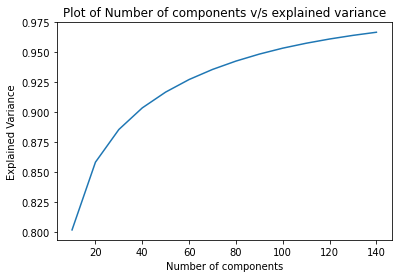

In [19]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    ###<your code>###
    svd = TruncatedSVD(n_components = dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum() )
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")

plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [20]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
###<your code>###
svd = TruncatedSVD(n_components = 140)
re_co_matrix = svd.fit_transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [21]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 236 doesn't contain word in vocab_list
g w r


document 289 doesn't contain word in vocab_list
beerage 


document 1042 doesn't contain word in vocab_list
hanks lotsly 


document 1150 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 1341 doesn't contain word in vocab_list
k k congratulation 


document 1486 doesn't contain word in vocab_list
 


document 2166 doesn't contain word in vocab_list
audrie lousy autocorrect


document 2214 doesn't contain word in vocab_list
s antha num corrct dane


document 2354 doesn't contain word in vocab_list
 


document 3081 doesn't contain word in vocab_list
u 


document 3581 doesn't contain word in vocab_list
 tf p


document 3658 doesn't contain word in vocab_list
 


document 3850 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli 


document 4109 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 435 doesn't contain word in vocab_list
er

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# training
# https://superlova.github.io/2020/05/31/np-delete%E7%9A%84%E4%BD%BF%E7%94%A8%E6%96%B9%E6%B3%95/
y_train_filter = np.delete(np.array(y_train), missing_train_list)

###<your code>###
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(doc_vec_train , y_train_filter)
train_pred = neigh.predict(doc_vec_train)
# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
###<your code>###
test_pred = neigh.predict(doc_vec_test)


In [23]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9669142471303174
train acc: 0.958670260557053
